In [10]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import metpy.calc as mpcalc

In [11]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

def plot_data(data, time):
    temp_var = data.variables['Temperature_isobaric']
    gph_var = data.variables['Geopotential_height_isobaric']
    u_wind_var850 = data.variables['u-component_of_wind_isobaric'][:] * units('m/s')
    v_wind_var850 = data.variables['v-component_of_wind_isobaric'][:] * units('m/s')
    time_var = data.variables[find_time_var(gph_var)]
    lat_var = data.variables['lat']
    lon_var = data.variables['lon']

    temp = temp_var[:].squeeze()
    lat = lat_var[:].squeeze()
    lon = lon_var[:].squeeze()
    gph_var = gph_var[:].squeeze()
    u_wind850 = u_wind_var850[:].squeeze()
    v_wind850 = v_wind_var850[:].squeeze()

    temp = units.Quantity(temp, 'kelvin')
    temp = temp.to('degC')

    u_wind850 = units.Quantity(u_wind850, 'm/s')
    v_wind850 = units.Quantity(v_wind850, 'm/s')

    wnd = mpcalc.wind_speed(u_wind850, v_wind850)
    wnd = wnd.to('kt')

    # Convert number of hours since the reference time into an actual date
    time = num2date(time_var[:].squeeze(), time_var.units)

    # Combine 1D latitude and longitudes into a 2D grid of locations
    lon_2d, lat_2d = np.meshgrid(lon, lat)

    # Smooth mslp data

    vor = mpcalc.vorticity(u_wind850.to('kt'), v_wind850.to('kt'), dx=13e3*units.meters, dy=13e3*units.meters)
    ## Smoothing

    vor = ndimage.gaussian_filter(vor, sigma=1, order=0)
    gph = ndimage.gaussian_filter(gph_var, sigma=2, order=0)

    mapcrs = ccrs.LambertConformal(central_longitude=-98, central_latitude=39)  
    datacrs = ccrs.PlateCarree() 
    #proj = ccrs.Stereographic(central_longitude=-85, central_latitude=40) 


    fig = plt.figure(figsize=(18,12)) 
    ax = fig.add_subplot(1, 1, 1, projection=mapcrs) 
    
    ax.set_extent([-120, -75, 25, 50], datacrs) 

    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=2)

    cf = ax.contour(lon_2d, lat_2d, gph, range(5000, 6000, 60), colors='black', transform=datacrs)
    ax.clabel(cf, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

    cf = ax.contourf(lon_2d, lat_2d, vor*1e5, range(0, 50, 1), cmap=plt.cm.YlOrRd,
                    transform=datacrs)
    plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, label = 'Cyclonic Vorticity (1x10^-5 s^-1)', shrink=.85)

    ax.barbs(lon_2d, lat_2d, u_wind850.m, v_wind850.m, pivot='middle', color='black', regrid_shape=12, transform=datacrs, zorder=2)
    plt.title('GFS 500MB: Vorticity (1x10^-5 s^-1), Geopotential Heights (m), Winds (kt)', loc='left')
    plt.title('{:s} UTC'.format(str(time)), loc='right')

    #plt.savefig(f"GFSReanalysis_{time.strftime('%Y%m%d%H')}z.png", bbox_inches='tight')
    plt.show()
    #plt.close()

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-gfs-g4-anl-files-old/201102/20110202/catalog.html?dataset=gfs-g4-anl-files-old/201102/20110202/gfsanl_4_20110202_0000_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-gfs-g4-anl-files-old/201102/20110202/catalog.xml?dataset=gfs-g4-anl-files-old/201102/20110202/gfsanl_4_20110202_0000_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


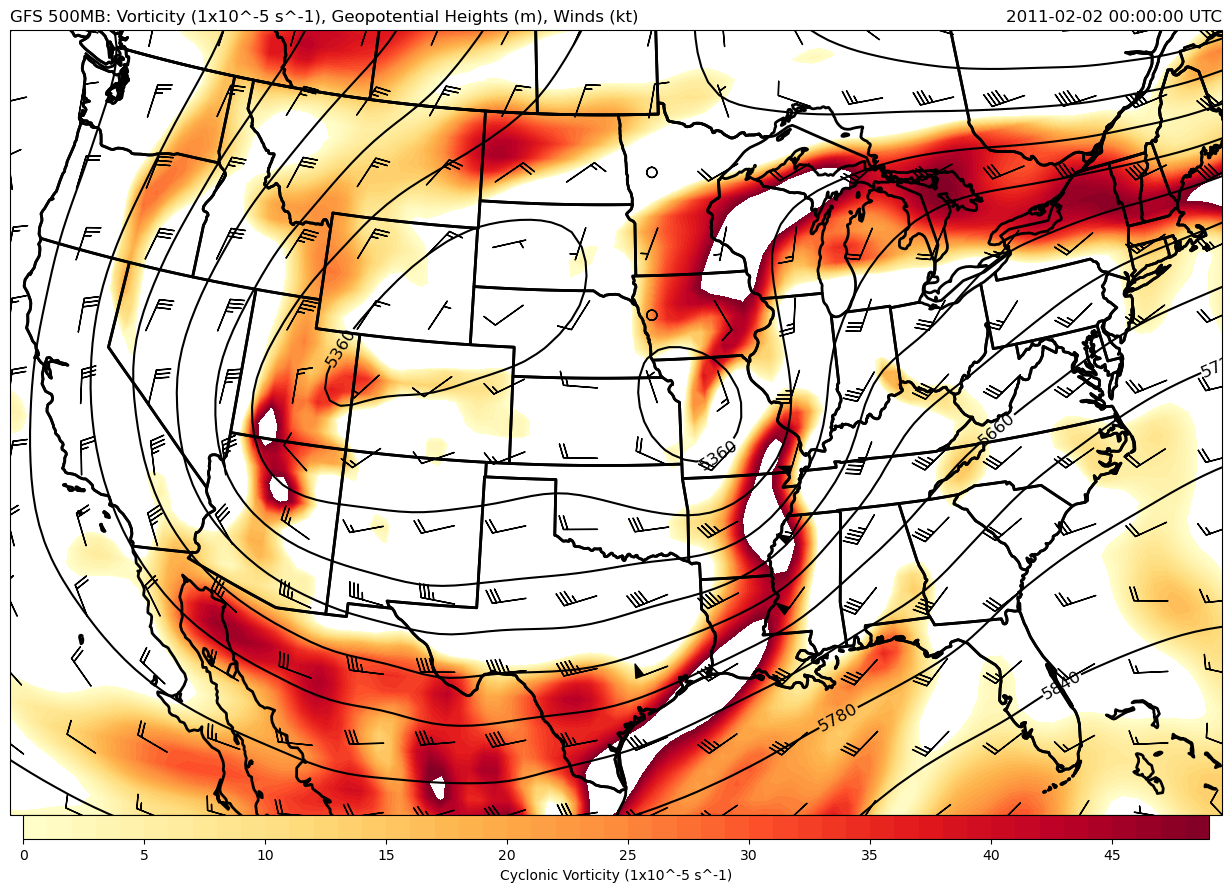

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-gfs-g4-anl-files-old/201102/20110202/catalog.html?dataset=gfs-g4-anl-files-old/201102/20110202/gfsanl_4_20110202_0000_003.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-gfs-g4-anl-files-old/201102/20110202/catalog.xml?dataset=gfs-g4-anl-files-old/201102/20110202/gfsanl_4_20110202_0000_003.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


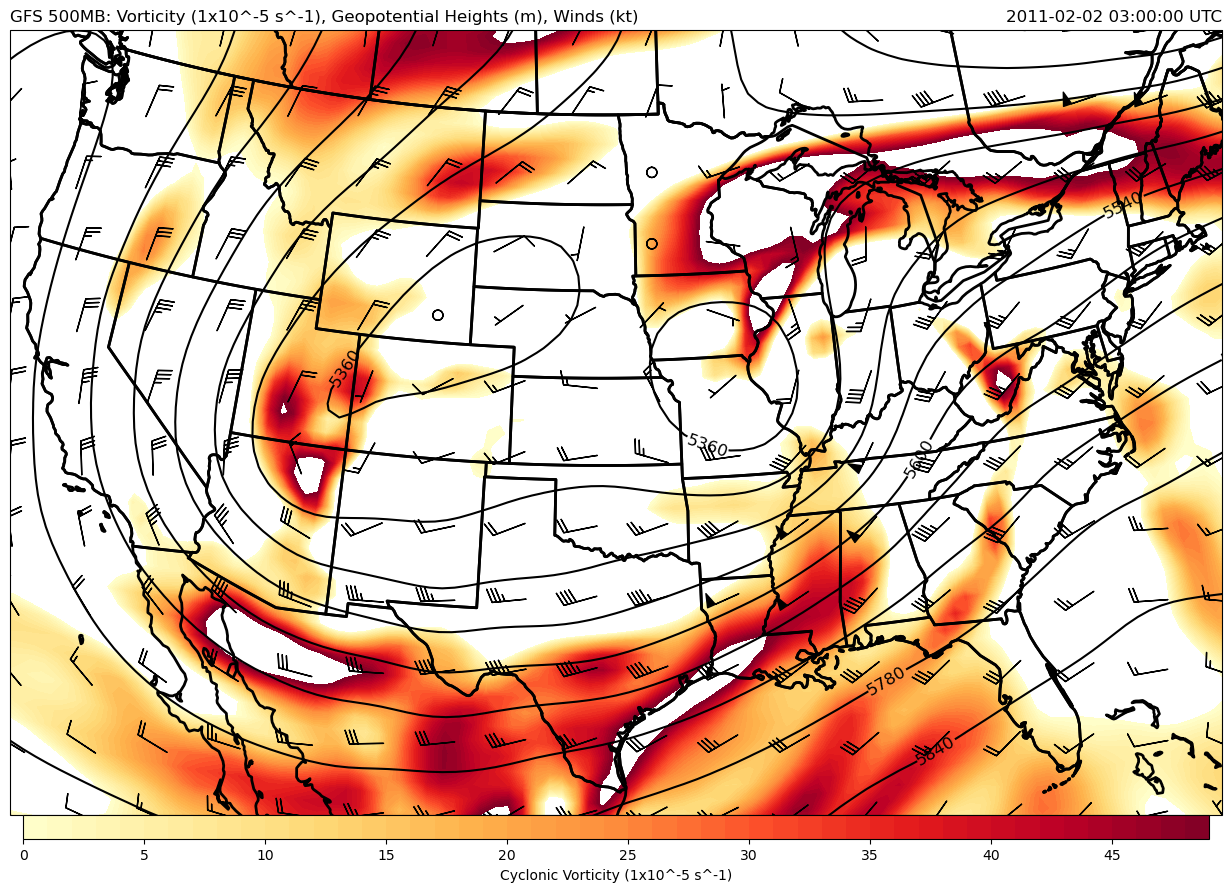

In [12]:
# Rest of your code
catalog_url_base = 'https://www.ncei.noaa.gov/thredds/catalog/model-gfs-g4-anl-files-old/201102/20110202/catalog.html'
forecast_hours = [str(i).zfill(3) for i in range(0, 6, 3)]  # Forecast hours 0, 3, and 6

for forecast_hour in forecast_hours:
    # Construct the catalog URL for the current forecast hour
    #catalog_url = f'{catalog_url_base}?dataset=gfs-g3-files/202305/20230501/gfs_3_20230501_0000_{forecast_hour}.grb2'
    catalog_url = f'{catalog_url_base}?dataset=gfs-g4-anl-files-old/201102/20110202/gfsanl_4_20110202_0000_{forecast_hour}.grb2'

    cat = TDSCatalog(catalog_url)
    ncss = cat.datasets[0].subset()
    query = ncss.query()
    query.variables('Temperature_isobaric','Geopotential_height_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
    query.vertical_level(50000)
    query.lonlat_box(north=65, south=15, east=-55, west=-140)
    query.accept('netcdf')

    data = ncss.get_data(query)
    time_var = data.variables[find_time_var(data.variables['Temperature_isobaric'])]
    time = num2date(time_var[:].squeeze(), time_var.units)
    plot_data(data, time)